In [6]:

!pip install kaggle

In [8]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [9]:

!kaggle competitions download -c nyc-taxi-trip-duration


!unzip train.zip
!unzip test.zip
!unzip sample_submission.zip


 93% 80.0M/85.8M [00:00<00:00, 126MB/s]
100% 85.8M/85.8M [00:00<00:00, 122MB/s]
Archive:  train.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of train.zip or
        train.zip.zip, and cannot find train.zip.ZIP, period.
Archive:  test.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test.csv                
Archive:  sample_submission.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sample_submission.csv   


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [11]:
# Load the training dataset
df_train = pd.read_csv('train.csv')

# Load the test dataset
df_test = pd.read_csv('test.csv')

# Display the first few rows of the training data
df_train.head()


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [12]:
# Handle missing values
df_train = df_train.dropna()

# Convert pickup and dropoff times to datetime
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])
df_train['dropoff_datetime'] = pd.to_datetime(df_train['dropoff_datetime'])

# Extract trip duration in minutes
df_train['trip_duration'] = (df_train['dropoff_datetime'] - df_train['pickup_datetime']).dt.total_seconds() / 60.0

# Extract features like pickup hour and day of the week
df_train['pickup_hour'] = df_train['pickup_datetime'].dt.hour
df_train['pickup_day_of_week'] = df_train['pickup_datetime'].dt.dayofweek

# Display updated dataframe
df_train.head()


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,7.583333,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,11.050000,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,35.400000,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,7.150000,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,7.250000,13,5


In [13]:
# Drop unnecessary columns
df_train = df_train.drop(columns=['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag'])

# Display the shape of the dataset after cleaning
df_train.shape


(1458644, 8)

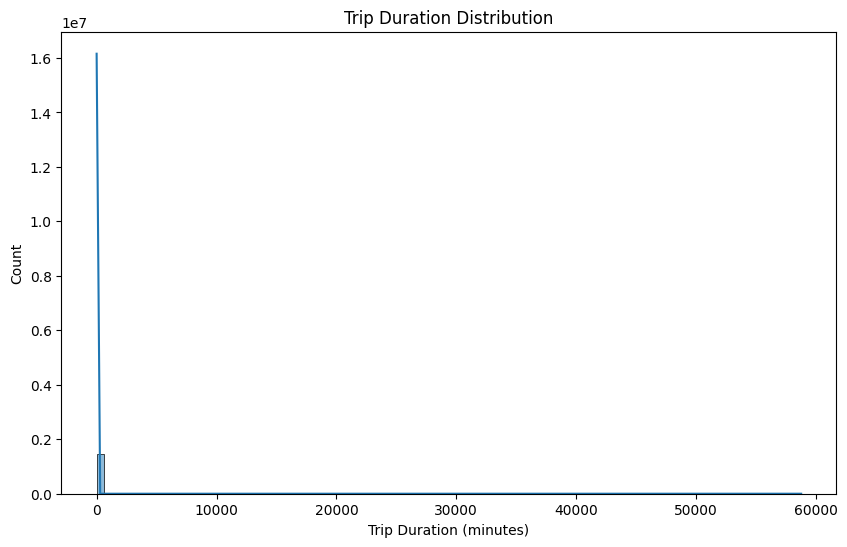

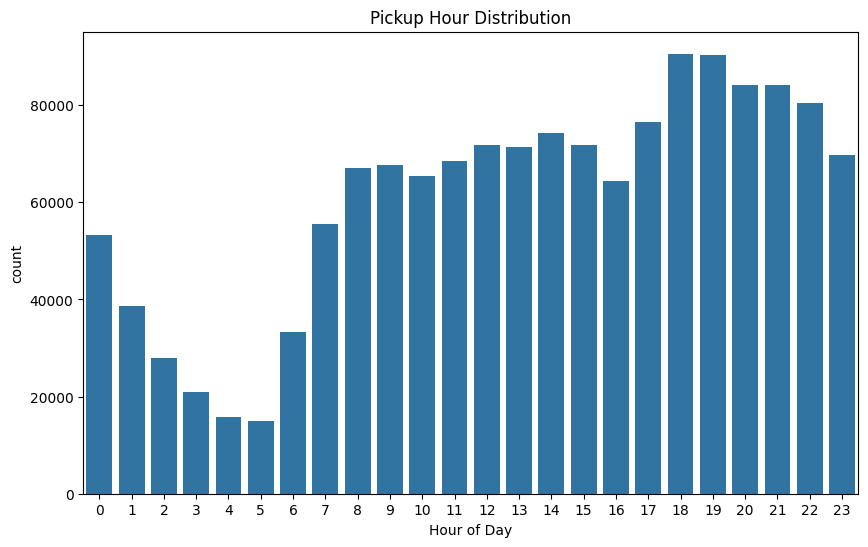

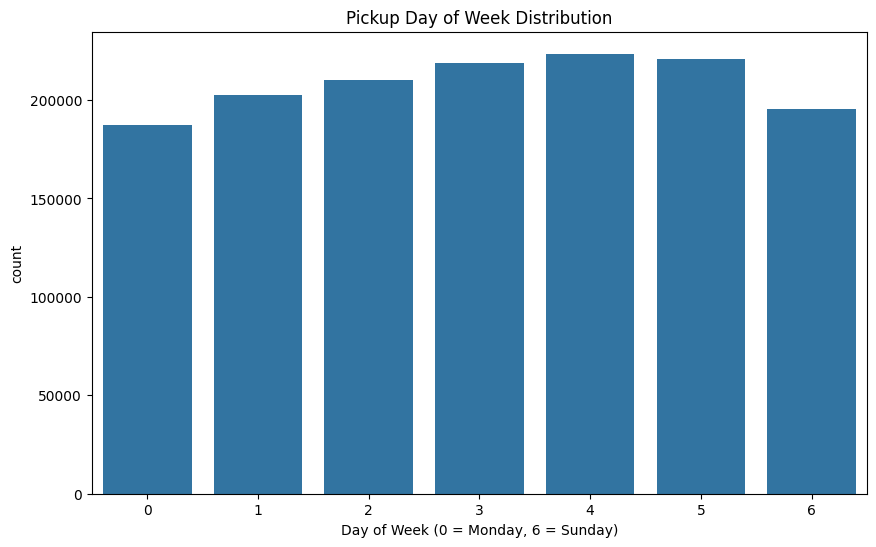

In [14]:
# Plot trip duration distribution
plt.figure(figsize=(10,6))
sns.histplot(df_train['trip_duration'], bins=100, kde=True)
plt.title('Trip Duration Distribution')
plt.xlabel('Trip Duration (minutes)')
plt.show()

# Plot pickup hour distribution
plt.figure(figsize=(10,6))
sns.countplot(x='pickup_hour', data=df_train)
plt.title('Pickup Hour Distribution')
plt.xlabel('Hour of Day')
plt.show()

# Plot pickup day of the week distribution
plt.figure(figsize=(10,6))
sns.countplot(x='pickup_day_of_week', data=df_train)
plt.title('Pickup Day of Week Distribution')
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.show()


In [15]:
# Define features and target variable
X = df_train[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'pickup_hour', 'pickup_day_of_week']]
y = df_train['trip_duration']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the train and test sets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (1166915, 6)
Test set shape: (291729, 6)


In [16]:
# Initialize Linear Regression model
lr_model = LinearRegression()

# Fit the model on the training data
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate the Linear Regression model
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression RMSE: {rmse_lr}")
print(f"Linear Regression R-squared: {r2_lr}")


Linear Regression RMSE: 54.12854609225663
Linear Regression R-squared: 0.004173346235968767


In [21]:
from sklearn.tree import DecisionTreeRegressor

# Initialize Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)

# Fit the model
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

print(f"Decision Tree RMSE: {rmse_dt}")
print(f"Decision Tree R-squared: {r2_dt}")


Decision Tree RMSE: 102.50747576749593
Decision Tree R-squared: -2.571429656869849


In [23]:
# Compare models
print(f"Linear Regression: RMSE = {rmse_lr}, R-squared = {r2_lr}")
print(f"Random Forest: RMSE = {rmse_dt}, R-squared = {r2_dt}")


Linear Regression: RMSE = 54.12854609225663, R-squared = 0.004173346235968767
Random Forest: RMSE = 102.50747576749593, R-squared = -2.571429656869849


In [25]:
# Check if the model is fitted
try:
    # This will raise an error if the model is not fitted
    _ = rf_model.estimators_[0]
    print("Model is fitted successfully.")
except IndexError:
    print("Model is not fitted. Please check the training step.")


Model is not fitted. Please check the training step.


In [26]:
# Load the test dataset
df_test = pd.read_csv('test.csv')

# Extract the necessary features from the test data
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])
df_test['pickup_hour'] = df_test['pickup_datetime'].dt.hour
df_test['pickup_day_of_week'] = df_test['pickup_datetime'].dt.dayofweek

# Define features for the test set
X_final_test = df_test[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'pickup_hour', 'pickup_day_of_week']]

# Check if the model is fitted before predicting
try:
    # Make predictions using the Random Forest model
    predictions = rf_model.predict(X_final_test)

    # Display the first few predictions
    print(predictions[:5])
except Exception as e:
    print(f"Error while making predictions: {e}")


Error while making predictions: list index out of range


In [28]:
import os
print(os.listdir())


['.config', 'train.zip', 'test.zip', 'sample_submission.csv', 'train.csv', 'test.csv', 'sample_submission.zip', 'nyc-taxi-trip-duration.zip', 'kaggle.json', 'sample_data']


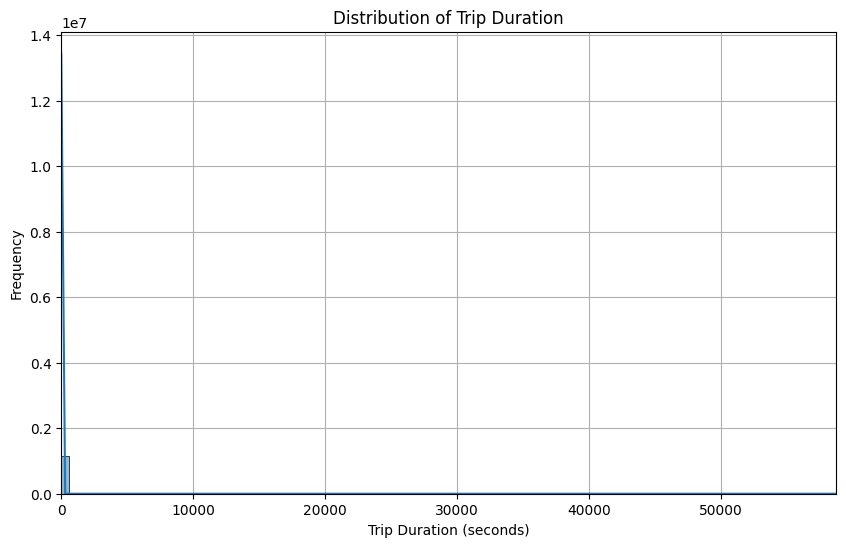

In [29]:
# Visualization 1: Distribution of Trip Duration
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=100, kde=True)
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Frequency')
plt.xlim(0, y_train.max())
plt.grid()
plt.show()


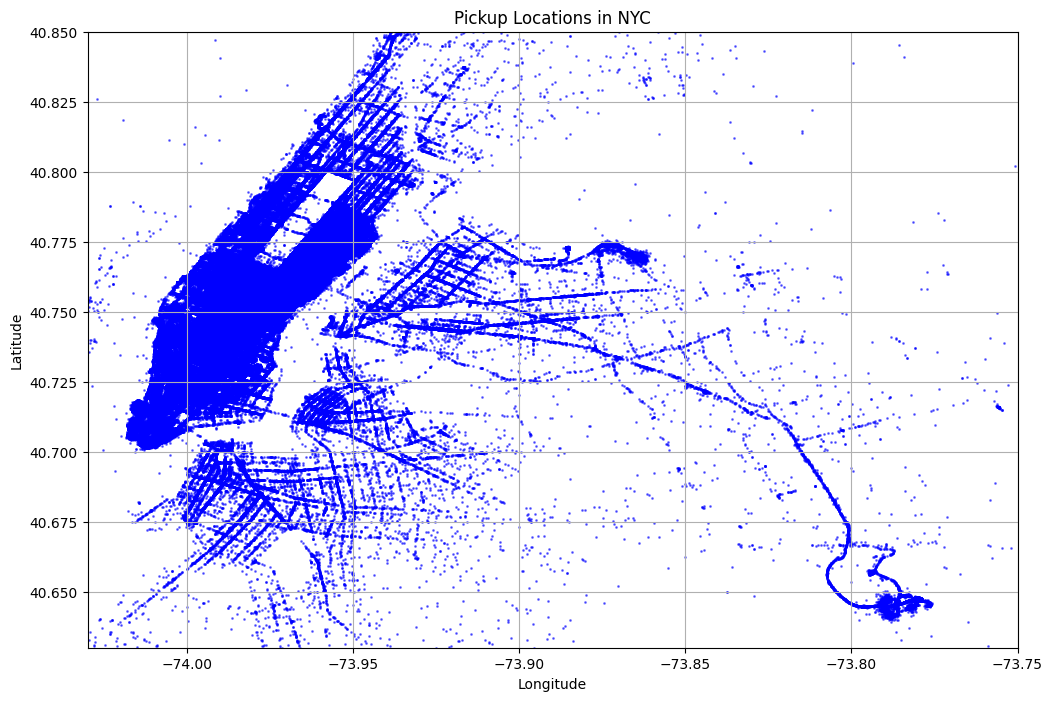

In [30]:
# Visualization 2: Pickup Locations Heatmap
plt.figure(figsize=(12, 8))

# Create a scatter plot of pickup locations
plt.scatter(df_train['pickup_longitude'], df_train['pickup_latitude'],
            alpha=0.5, s=1, color='blue')

plt.title('Pickup Locations in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([-74.03, -73.75])
plt.ylim([40.63, 40.85])
plt.grid()
plt.show()


<ipython-input-31-89f972223388>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pickup_hour', y='trip_duration', data=avg_duration_by_hour, palette='viridis')


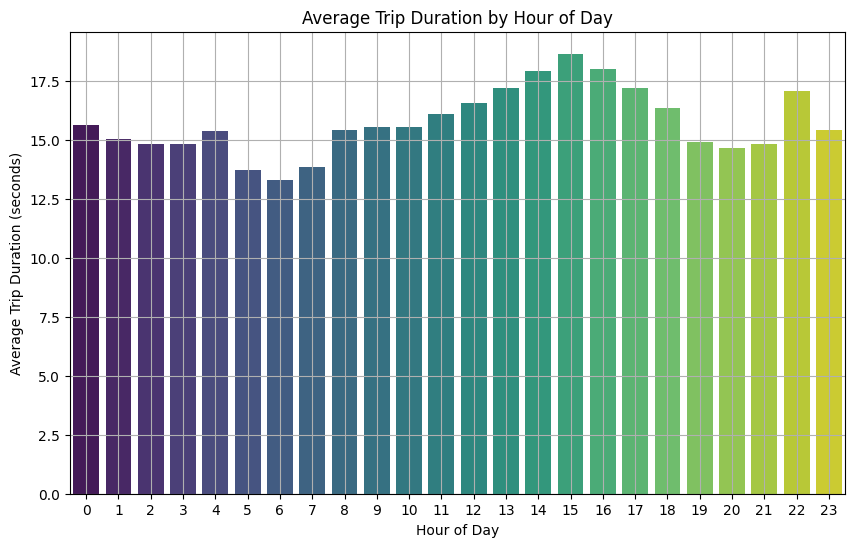

In [31]:
# Visualization 3: Average Trip Duration by Hour of Day
avg_duration_by_hour = df_train.groupby('pickup_hour')['trip_duration'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='pickup_hour', y='trip_duration', data=avg_duration_by_hour, palette='viridis')
plt.title('Average Trip Duration by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Trip Duration (seconds)')
plt.xticks(rotation=0)
plt.grid()
plt.show()


<ipython-input-32-4cc99cf9129b>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pickup_day_of_week', y='trip_duration', data=avg_duration_by_day, palette='magma')


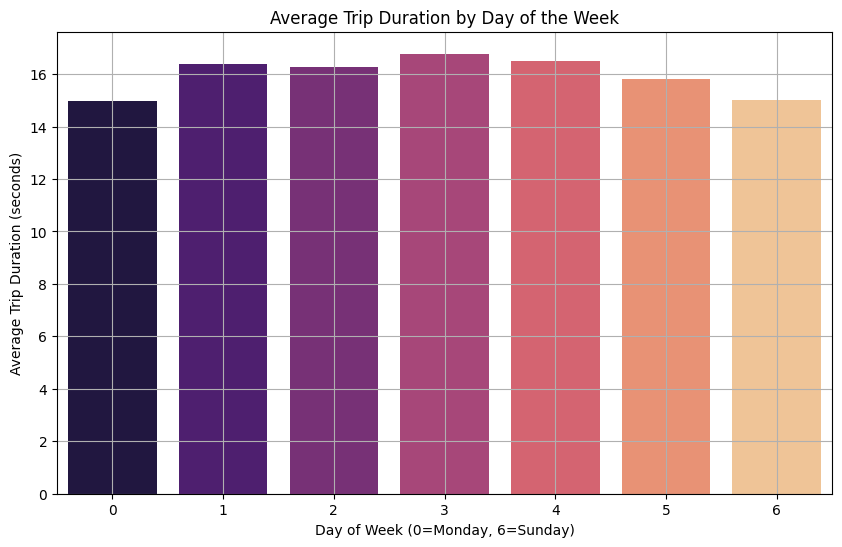

In [32]:
# Visualization 4: Average Trip Duration by Day of the Week
avg_duration_by_day = df_train.groupby('pickup_day_of_week')['trip_duration'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='pickup_day_of_week', y='trip_duration', data=avg_duration_by_day, palette='magma')
plt.title('Average Trip Duration by Day of the Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Trip Duration (seconds)')
plt.xticks(rotation=0)
plt.grid()
plt.show()


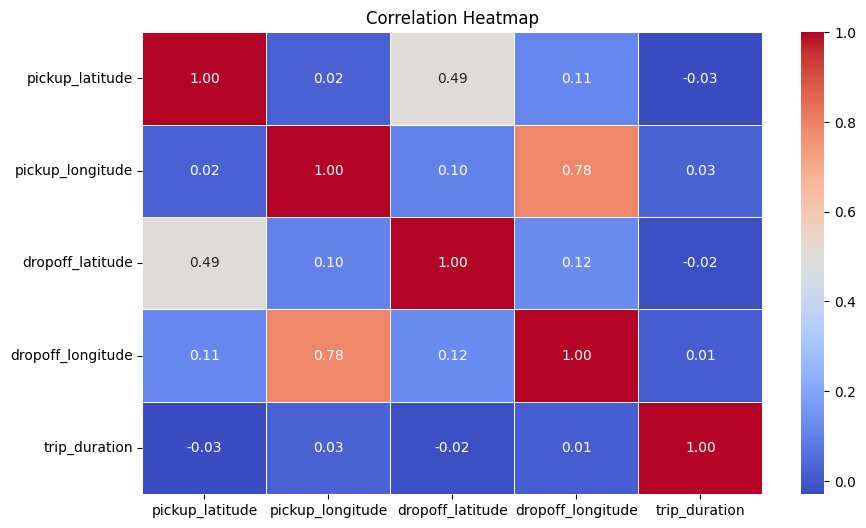

In [33]:
# Visualization 5: Correlation Heatmap
plt.figure(figsize=(10, 6))
correlation_matrix = df_train[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'trip_duration']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


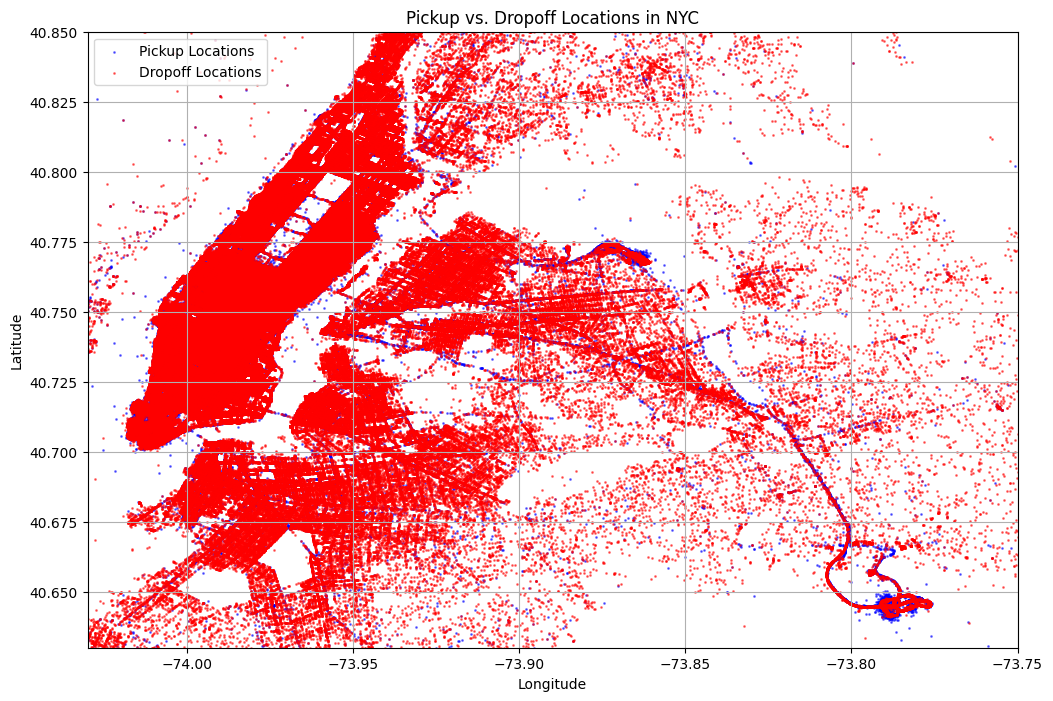

In [34]:
# Visualization 6: Scatter Plot of Pickup vs. Dropoff Locations
plt.figure(figsize=(12, 8))
plt.scatter(df_train['pickup_longitude'], df_train['pickup_latitude'],
            alpha=0.5, s=1, color='blue', label='Pickup Locations')
plt.scatter(df_train['dropoff_longitude'], df_train['dropoff_latitude'],
            alpha=0.5, s=1, color='red', label='Dropoff Locations')
plt.title('Pickup vs. Dropoff Locations in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([-74.03, -73.75])
plt.ylim([40.63, 40.85])
plt.legend()
plt.grid()
plt.show()
